# LSTM

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import math
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
#MODEL PARAMETER
DATA_OFFSET     = 1                                                 # data preprocess offset
INPUT_SIZE      = 1                                                 # the number of input data feature
NUM_LAYERS      = 1                                                 # staked RNN
HIDDEN_SIZE     = 8                                                 # hidden layer 8
NUM_CLASSES     = 1                                                 # the number of output data feature

# HYPERPARAMETER
SEQ_LEN         = 20                                                # sequence length
BATCH_SIZE      = 9984                                              # batch size (32 * 312)
CRITERION       = nn.MSELoss()                                      # mean square error
LEARNING_RATE   = 1e-3                                              # learning rate
NUM_EPOCHS      = 100                                               # epoch

#DATA PARAMETER
TRAIN_NUM          = 600                                            # train number == #iteration
TEST_NUM           = 200                                            # test number
DATASET_NUM        = TRAIN_NUM + TEST_NUM # + DATA_OFFSET           # dataset number (800)
SaturationForRange = SEQ_LEN + DATA_OFFSET                          # prevent idx error

# PlOT PARAMETER
SET_NUM         = 9984                                              # set size
SAMPLE_PER_SET  = 100                                               # sample size per set
SAMPLE_NUM      = SET_NUM * SAMPLE_PER_SET                          # sample: 998,400
TEST_SIZE       = SET_NUM * TEST_NUM                                # test size (9984 * 180)
SPLIT           = SET_NUM * DATASET_NUM - TEST_SIZE                 # plot test number (9984 * 800 - 9984 * 200) = train number

# Data Padding

data가 반복되기 때문에 앞에 data를 padding 하는 것이 올바른 방안이라고 생각

In [3]:
pl = pd.read_table(f'C:/Users/DCLAB/Desktop/Dataset/dataset.csv', sep=',')

# LSTM

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [5]:
import numpy as np
import torch
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# seq_data
def seq_data(x, y, seq_len): # sequence length
    X_seq = []
    y_seq = []
    
    for i in range(len(x)-SaturationForRange):
            X_seq.append(x[i:i+seq_len])
            y_seq.append(y[i+seq_len+1])

    X_seq = np.array(X_seq)        
    y_seq = np.array(y_seq)

    return torch.FloatTensor(X_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

def train_test_seperate(X, y, seq_len, split, batch_size):
    X_seq, y_seq = seq_data(X, y, seq_len)
    X_train_seq = X_seq[:split]
    y_train_seq = y_seq[:split]
    X_test_seq = X_seq[split:]
    y_test_seq = y_seq[split:]

    # Dataset
    train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
    test  = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)

    # Dataloader -> batch_size
    train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
    test_loader  = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

+1의 index가 넘어가기 때문에, 21만큼 마지막 dataset에 padding해줘야하지만 귀찮은 관계로 생략 
랜덤 수라서 잘 안걸림 -> 갓챠 시뮬레이션

In [6]:
# Meta learning (Few shot dataset - random: 1 ~ 7,987,200)

def sample_data(x, y, seq_len, FewShotDataNum):
    x_seq = []
    y_seq = []
    
    #not hidden size -> map dataset (8)
    RandomDataSetIdx = random.randint(0, 5)
    Idx_RangeX = RandomDataSetIdx * SAMPLE_NUM
    Idx_RangeY = Idx_RangeX + SAMPLE_NUM - SaturationForRange - FewShotDataNum
    #Random location per 1 random Map
    RandomDataSetloc = random.randint(Idx_RangeX, Idx_RangeY)
    
    for i in range(RandomDataSetloc, RandomDataSetloc + FewShotDataNum):
            x_seq.append(x[i:i+seq_len])
            y_seq.append(y[i+seq_len+1])

    x_seq = np.array(x_seq)        
    y_seq = np.array(y_seq)

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

In [7]:
X = pl[["Realized_Power"]].values
y = pl["Real_block"].values

In [8]:
#train, test dataset
train_loader, test_loader = train_test_seperate(X, y, SEQ_LEN, SPLIT, BATCH_SIZE)

In [9]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

test_features, test_labels = next(iter(test_loader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")

Feature batch shape: torch.Size([9984, 20, 1])
Labels batch shape: torch.Size([9984, 1])
Feature batch shape: torch.Size([9984, 20, 1])
Labels batch shape: torch.Size([9984, 1])


In [10]:
def model_training(train_loader, num_epochs, model, criterion, optimizer): 
    loss_graph = []
    n = len(train_loader)

    for epoch in range(num_epochs): # epoch
        running_loss = 0.0  
        
        for i, data in enumerate(train_loader): # batch 
            seq, target = data
            out = model(seq)
            loss = criterion(out, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss_graph.append(running_loss/n)
        
        if epoch % 10 == 0:
            print('[epoch: %d] loss: %.8f' %(epoch, running_loss/n))
    
    plt.figure(figsize=(20,10))
    plt.plot(loss_graph)

LSTM layer 구현

In [11]:
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True) :
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)  #
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
        self.reset_parameters()
        
    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std)
            
    def forward(self, x, hidden_size) :
        hx, cx = hidden_size
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        InputGate, ForgerGate, CellGate, OutGate = gates.chunk(4, -1)
        
        InputGate = F.sigmoid(InputGate)          
        ForgerGate = F.sigmoid(ForgerGate)  
        CellGate = F.tanh(CellGate)         
        OutGate = F.sigmoid(OutGate)        
        
        cy = torch.mul(cx, ForgerGate) + torch.mul(InputGate, CellGate)
        hy = torch.mul(OutGate, F.tanh(cy))
        
        return (hy, cy)

In [12]:
class MAMLModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device, num_classes):
        super(MAMLModel, self).__init__()
        self.input_size = input_size
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size*SEQ_LEN, num_classes) #hidden size per length
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h0 = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)
        c0 = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)

        outs = []
        cn = c0[0,:,:]
        hn = h0[0,:,:]
    
        for seq in range(x.size(1)) :
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))
            outs.append(hn.unsqueeze(1))
        
        out = torch.cat(outs, dim=1) #10, 20, 8
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out
    
    # FewshotDataset -> initial point
    def parameterised(self, x, weights):
        W_ii, W_if, W_ig, W_io = weights[0].split(8, dim=0)
        b_ii, b_if, b_ig, b_io = weights[2].split(8, dim=0)

        W_hi, W_hf, W_hg, W_ho = weights[1].split(8, dim=0)
        b_hi, b_hf, b_hg, b_ho = weights[3].split(8, dim=0)

        h_0 = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)
        c_0 = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)
        out = []
        
        c_n = c_0[0,:,:]
        h_n = h_0[0,:,:]

        for seq in range(x.size(1)):
            i_t = torch.sigmoid(F.linear(x[:, seq, :], W_ii, b_ii) + F.linear(h_n, W_hi, b_hi))
            f_t = torch.sigmoid(F.linear(x[:, seq, :], W_if, b_if) + F.linear(h_n, W_hf, b_hf))
            g_t = torch.tanh(F.linear(x[:, seq, :], W_ig, b_ig) + F.linear(h_n, W_hg, b_hg))
            o_t = torch.sigmoid(F.linear(x[:, seq, :], W_io, b_io) + F.linear(h_n, W_ho, b_ho))
            c_n = f_t * c_n + i_t * g_t
            h_n = o_t * torch.tanh(c_n) # (10, 8) x 20
            out.append(h_n.unsqueeze(1))

        out = torch.cat(out, dim=1) #10, 20, 8
        out = out.reshape(out.shape[0], -1)
        x = F.linear(out, weights[4], weights[5])
        x = torch.sigmoid(x)

        return x


In [13]:
model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   num_layers=NUM_LAYERS, 
                   num_classes=NUM_CLASSES, 
                   device=device)

model=model.to(device)

# model weights
0 -> torch size (x2h)

1 -> torch size (h2h)

2 -> 0의 bias

3 -> 1의 bias

4 -> linear

5 -> bias

In [14]:
for name, param in enumerate(model.parameters()):
    print(name,param.shape)

0 torch.Size([32, 1])
1 torch.Size([32, 8])
2 torch.Size([32])
3 torch.Size([32])
4 torch.Size([1, 160])
5 torch.Size([1])


In [15]:
class MAML():
    def __init__(self, model, inner_lr, meta_lr, K=10, inner_steps=1, tasks_per_meta_batch=10):
        
        # important objects
        self.model = model
        self.weights = list(model.parameters()) # the maml weights we will be meta-optimising
        self.criterion = CRITERION
        self.meta_optimiser = torch.optim.Adam(self.weights, meta_lr)
        
        # hyperparameters
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps # with the current design of MAML, >1 is unlikely to work well 
        self.tasks_per_meta_batch = tasks_per_meta_batch 
        
        # metrics
        self.plot_every = 100
        self.print_every = 1000
        self.meta_losses = []
    
    #Fewshot Dataset
    def inner_loop(self):
        # reset inner model to current maml weights
        temp_weights = [w.clone() for w in self.weights]
        
        X = pl[["Realized_Power"]].values
        y = pl["Real_block"].values
        
        X, y = sample_data(X, y, SEQ_LEN, self.K)

        # perform training on data sampled from task
        for step in range(8):
            loss = self.criterion(self.model.parameterised(X, temp_weights), y) / self.K
            # compute grad and update inner loop weights
            grad = torch.autograd.grad(loss, temp_weights, allow_unused=True) #True extremely important
            modified_tuple = tuple(0 if item is None else item for item in grad)
            temp_weights = [w - self.inner_lr * g for w, g in zip(temp_weights, modified_tuple)]
        
        self.weights = temp_weights
    
    def main_loop(self, num_iterations):
        epoch_loss = 0
        meta_loss = 0

        # inner_loop -> meta learning (Few-shot dataset)
        for i in range(self.tasks_per_meta_batch):
            self.inner_loop()
            
        for iteration in range(1, num_iterations+1):
            # compute meta gradient of loss with respect to maml weights
            X = pl[["Realized_Power"]].values
            y = pl["Real_block"].values
            
            seq, taget = sample_data(X, y, SEQ_LEN, self.K)
            out = self.model(seq)
            meta_loss = self.criterion(out, taget) / self.K
            model.zero_grad()
            meta_loss.backward()
            self.meta_optimiser.step()
                    
            # log metrics
            epoch_loss += meta_loss.item() / self.tasks_per_meta_batch

            # # loss < 0.01 stop
            # if epoch_loss < 0.000005:
            #     return print("stop iteration: {}", iteration)

            if iteration % self.print_every == 0:
                print("{}/{}. loss: {}".format(iteration, num_iterations, epoch_loss / self.plot_every))
            
            if iteration % self.plot_every == 0:
                self.meta_losses.append(epoch_loss / self.plot_every)
                epoch_loss = 0

In [16]:
maml = MAML(model, inner_lr=0.001, meta_lr=0.001)

In [17]:
maml.main_loop(num_iterations=10000)

1000/10000. loss: 0.0023421793030342078
2000/10000. loss: 0.002228256826970029
3000/10000. loss: 0.0021382900364522377
4000/10000. loss: 0.0021861405844043453
5000/10000. loss: 0.002037885294007722
6000/10000. loss: 0.001901520261052608
7000/10000. loss: 0.0017770074005007445
8000/10000. loss: 0.0016073970250256918
9000/10000. loss: 0.0016032510793892066
10000/10000. loss: 0.0014873812378588052


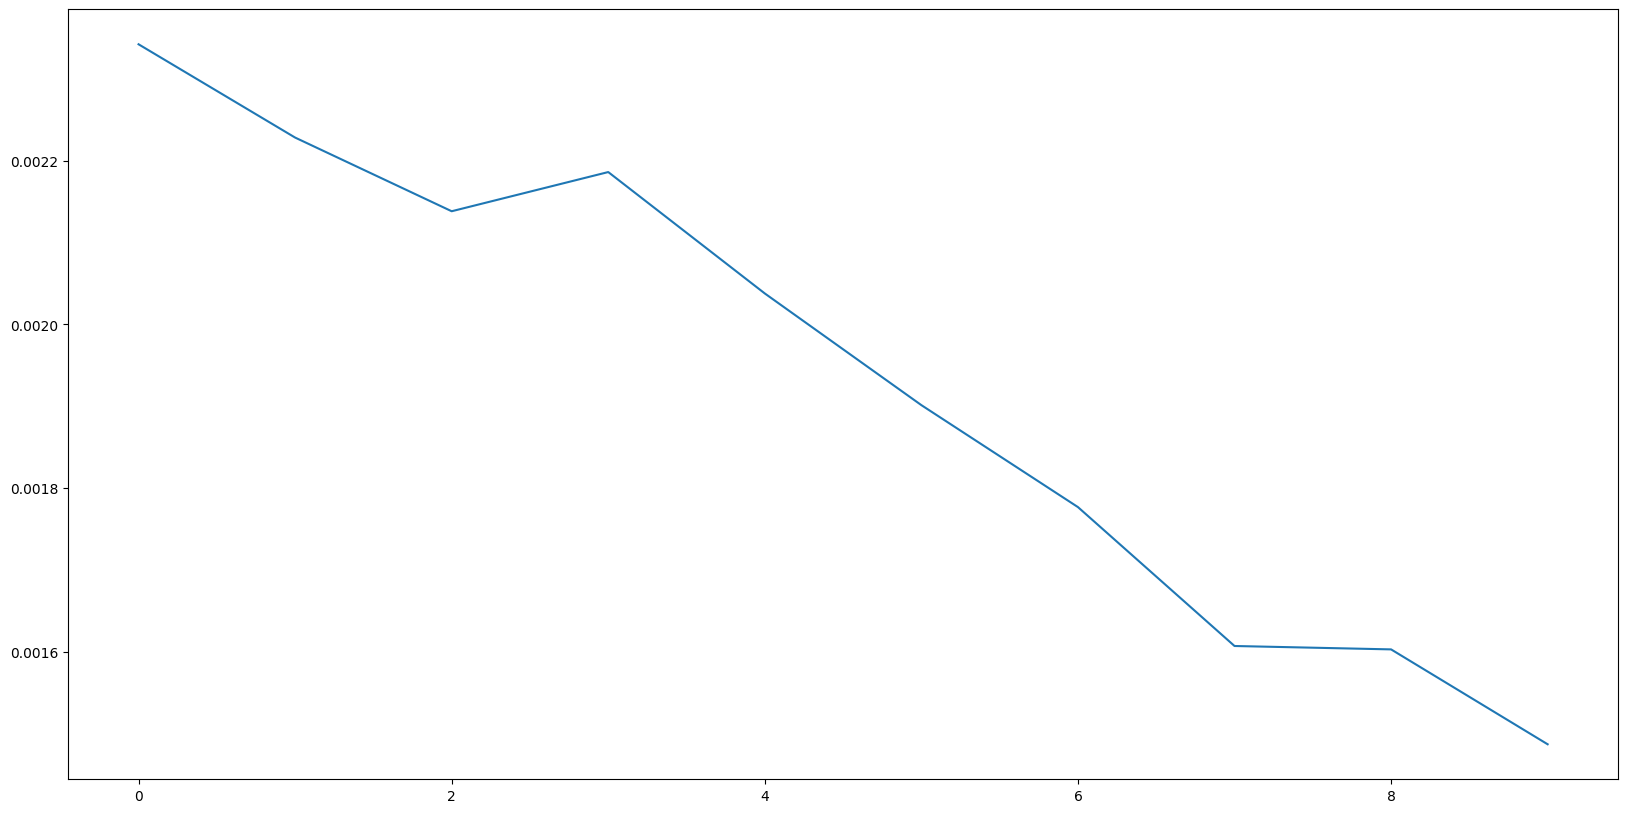

In [18]:
plt.figure(figsize=(20,10))
plt.plot(maml.meta_losses)

In [ ]:
torch.save(model.state_dict(), "C:/Users/DCLAB/Desktop/model.pt")

# MetaLearning 적용 x -> model

In [19]:
def mixed_pretrained(iterations=500, K=10):
    """
    returns a model pretrained on a selection of ``iterations`` random tasks.
    """
    
    # set up model
    pretrain_model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   num_layers=NUM_LAYERS,
                   num_classes=NUM_CLASSES, 
                   device=device).to(device)
    
    optimiser = torch.optim.Adam(pretrain_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    X = pl[["Realized_Power"]].values
    y = pl["Real_block"].values

    # fit the model
    for i in range(iterations):
        seq, target = sample_data(X, y, SEQ_LEN, K)
        out = pretrain_model(seq)
        #print(seq, target) = feature, label
        loss = criterion(out, target) 
        pretrain_model.zero_grad()
        loss.backward()
        optimiser.step()
        
    return pretrain_model

In [20]:
pretrained_model = mixed_pretrained(10000, 10).to(device)

In [ ]:
torch.save(pretrained_model.state_dict(), "C:/Users/DCLAB/Desktop/pretrain_model.pt")

# Result 1

In [21]:
def model_functions_at_training(initial_model, X, y, sampled_steps, optim=torch.optim.Adam, lr=0.01):
    """
    trains the model on X, y and measures the loss curve.
    
    for each n in sampled_steps, records model(x_axis) after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    
    model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   num_layers=NUM_LAYERS,
                   num_classes=NUM_CLASSES, 
                   device=device).to(device)

    model.load_state_dict(initial_model.state_dict())
    criterion = CRITERION
    optimiser = optim(model.parameters(), lr)

    # train model on a random task
    num_steps = max(sampled_steps)
    K = X.shape[0]
    
    losses = []
    outputs = {}

    for step in range(1, num_steps+1):
        loss = criterion(model(X), y) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()

        # plot the model function
        if step in sampled_steps:
            outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
            
    outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
    
    return outputs, losses

In [22]:
def plot_sampled_performance(initial_model, model_name, X, y, K, optim=torch.optim.Adam, lr=0.01):
    
    sampled_steps=[1,10]
    outputs, losses = model_functions_at_training(initial_model, 
                                                  X, y, 
                                                  sampled_steps=sampled_steps,
                                                  optim=optim, 
                                                  lr=lr)

    plt.figure(figsize=(15,5))
    x_axis = np.linspace(0, K-1, K)
    # plot the model functions
    plt.subplot(1, 2, 1)
    
    plt.plot(y.cpu(), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x_axis, y.cpu(), label='data')
    
    for step in sampled_steps:
        if step == 1:
            plt.plot(outputs[step], '-.', color=(0.5, 0, 0, 1),
                    label='model after {} steps'.format(step))
        elif step == 10:
            plt.plot(outputs[step], '*-', color=(0.5, 0, 0, 1),
                 label='model after {} steps'.format(step))

    plt.legend(loc='lower right')
    plt.title("Model fit: {}".format(model_name))

    # plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title("Loss over time")
    plt.xlabel("gradient steps taken")
    plt.show()

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_7984\3693235491.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_7984\3693235491.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()


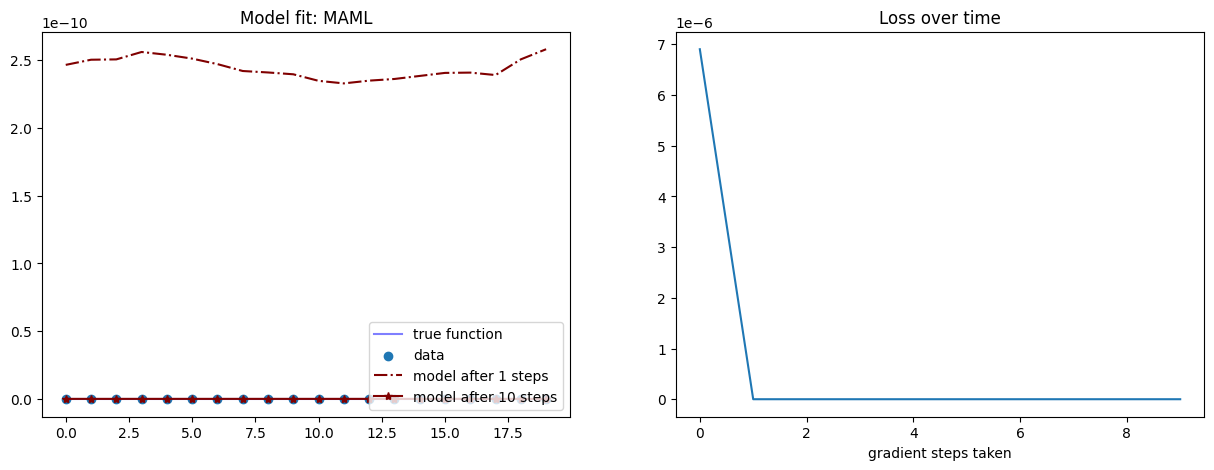

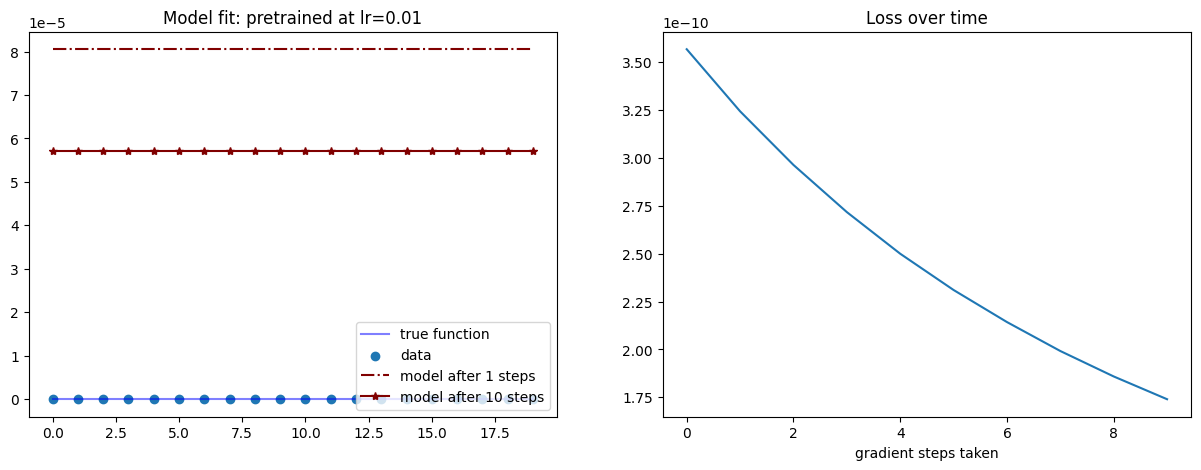

In [23]:
K = 20

X = pl[["Realized_Power"]].values
y = pl["Real_block"].values
seq, target = sample_data(X, y, SEQ_LEN, K)

plot_sampled_performance(maml.model, 'MAML', seq, target, K)
plot_sampled_performance(pretrained_model, 'pretrained at lr=0.01', seq, target, K)

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_7984\3693235491.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_7984\3693235491.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()


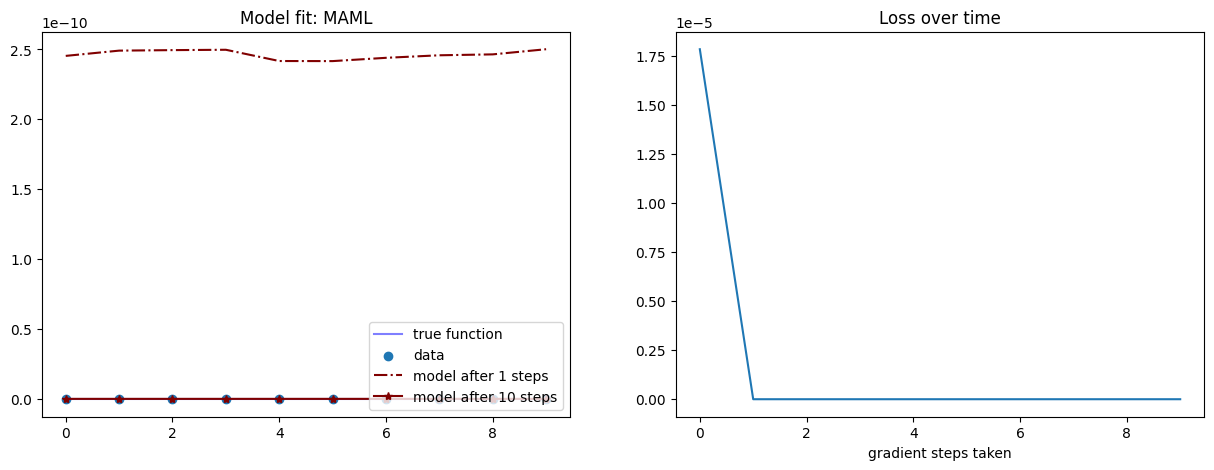

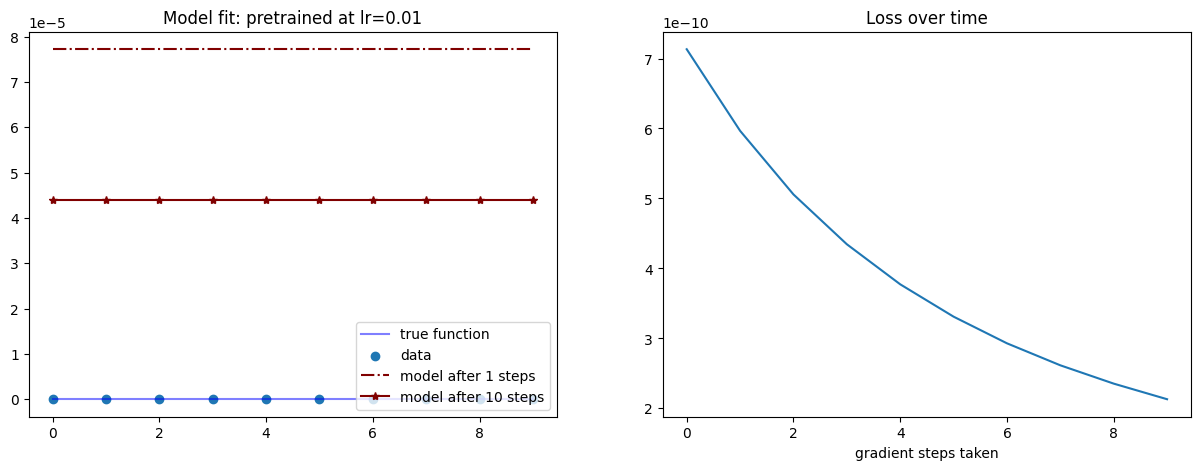

In [24]:
K = 10

X = pl[["Realized_Power"]].values
y = pl["Real_block"].values
seq, target = sample_data(X, y, SEQ_LEN, K)

plot_sampled_performance(maml.model, 'MAML', seq, target, K)
plot_sampled_performance(pretrained_model, 'pretrained at lr=0.01', seq, target, K)

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_7984\3693235491.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_7984\3693235491.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()


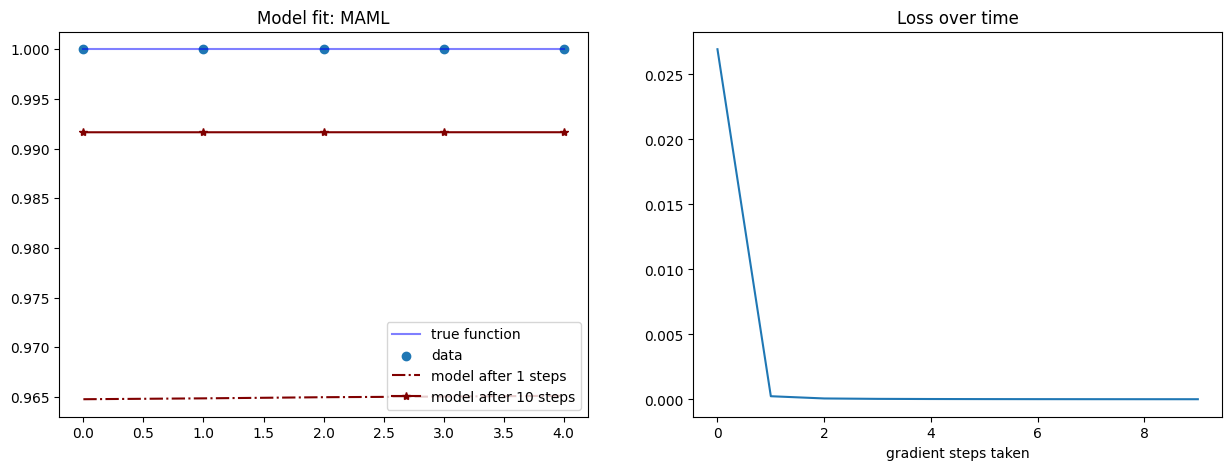

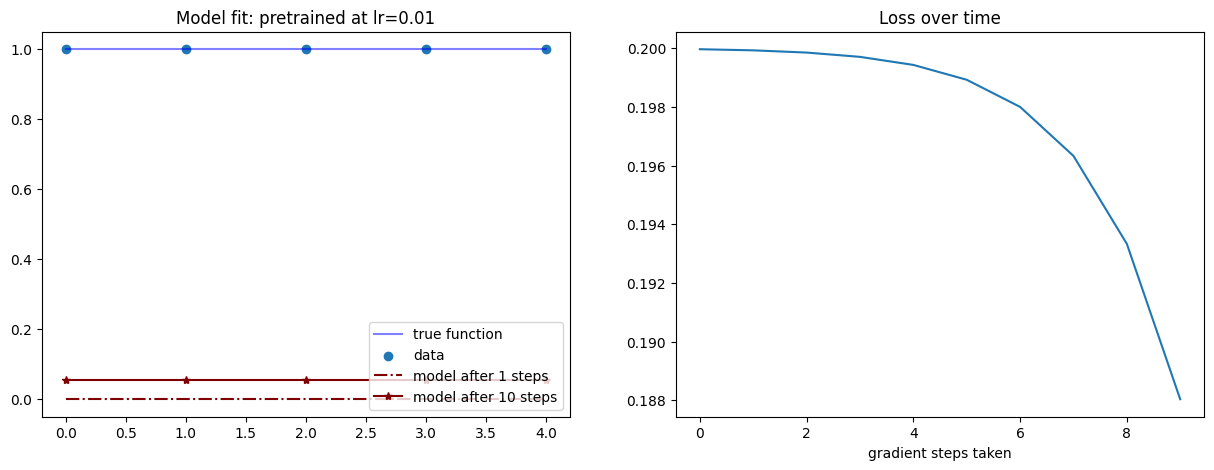

In [25]:
K = 5

X = pl[["Realized_Power"]].values
y = pl["Real_block"].values
seq, target = sample_data(X, y, SEQ_LEN, K)

plot_sampled_performance(maml.model, 'MAML', seq, target, K)
plot_sampled_performance(pretrained_model, 'pretrained at lr=0.01', seq, target, K)

# Result 2

In [26]:
X = pl[["Realized_Power"]].values
y = pl["Real_block"].values

In [27]:
train_loader, test_loader = train_test_seperate(X, y, SEQ_LEN, SPLIT, BATCH_SIZE)

# Meta Learning

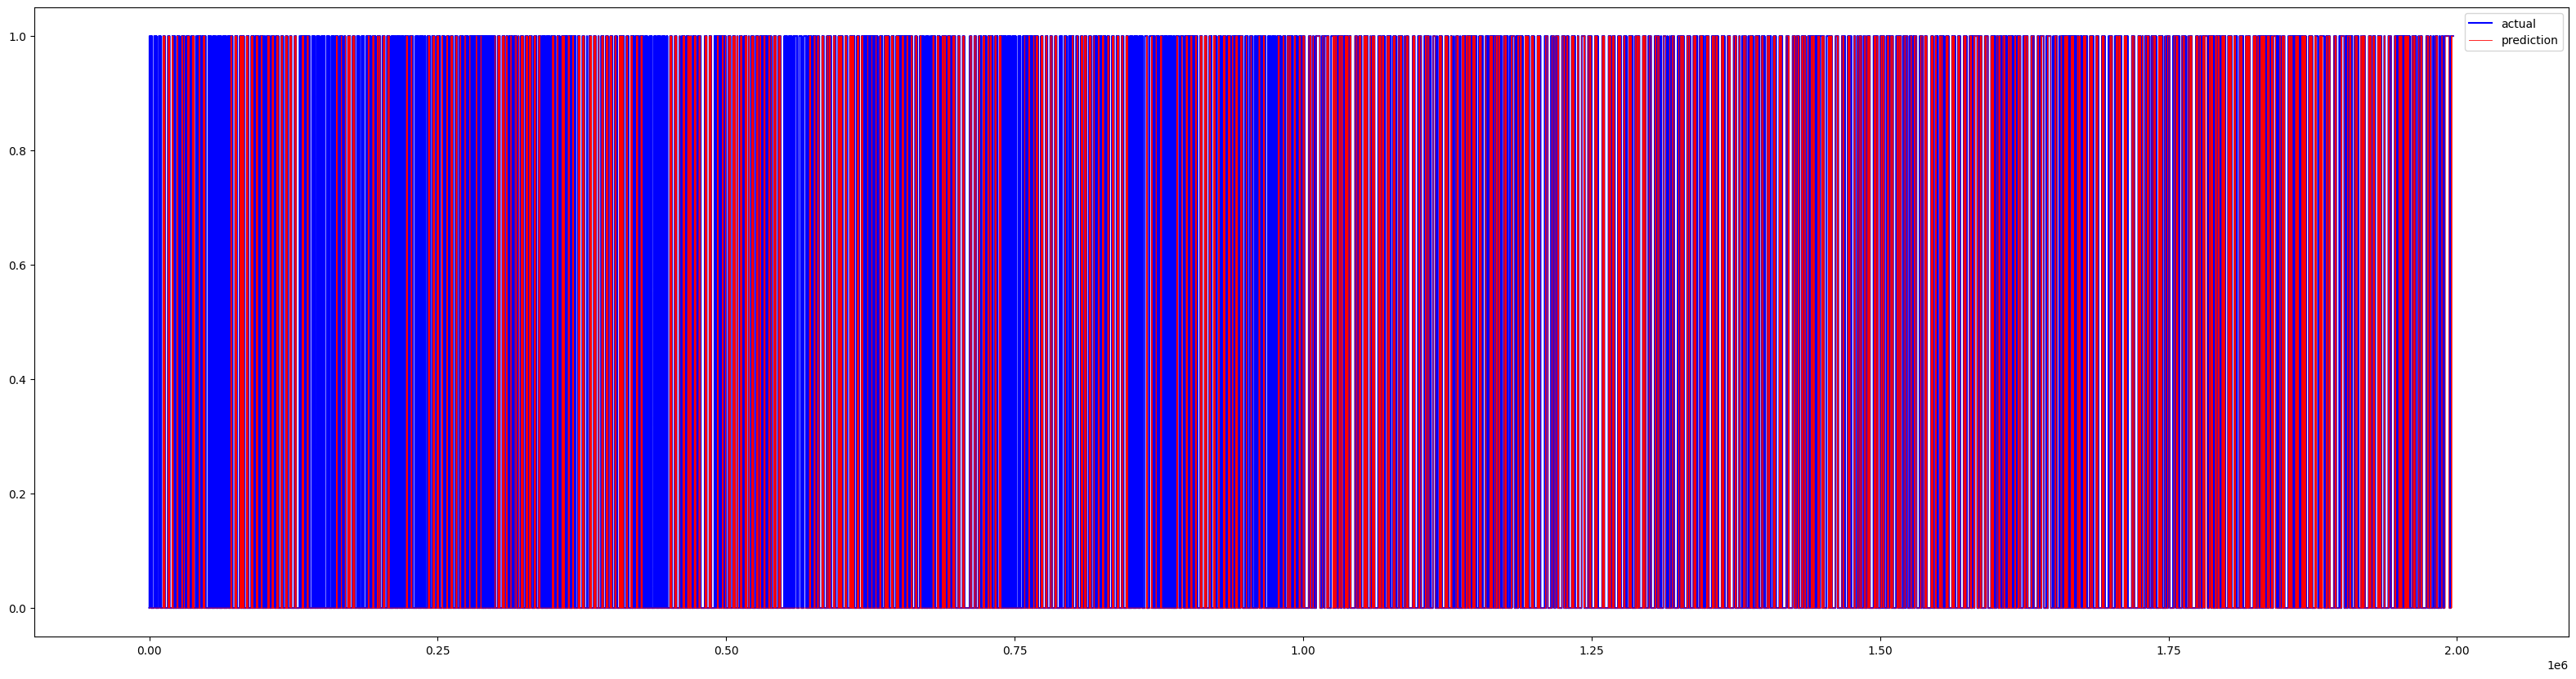


----------------------------------------------
the number of correct 1602800
the number of uncorrect 393979

confusion matrix
TP: 424458
TN: 1178342
FP: 11767
FN: 382212

accuracy: 0.8026927366523786


In [28]:
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []
    for data in test_loader:
        seq, target = data 
        out = maml.model(seq)
        targetting += target.cpu().numpy().tolist()
        test_pred += out.cpu().numpy().round().tolist()
        
    actual = targetting
    total = test_pred       

    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

# 일반모델 few-shot learning

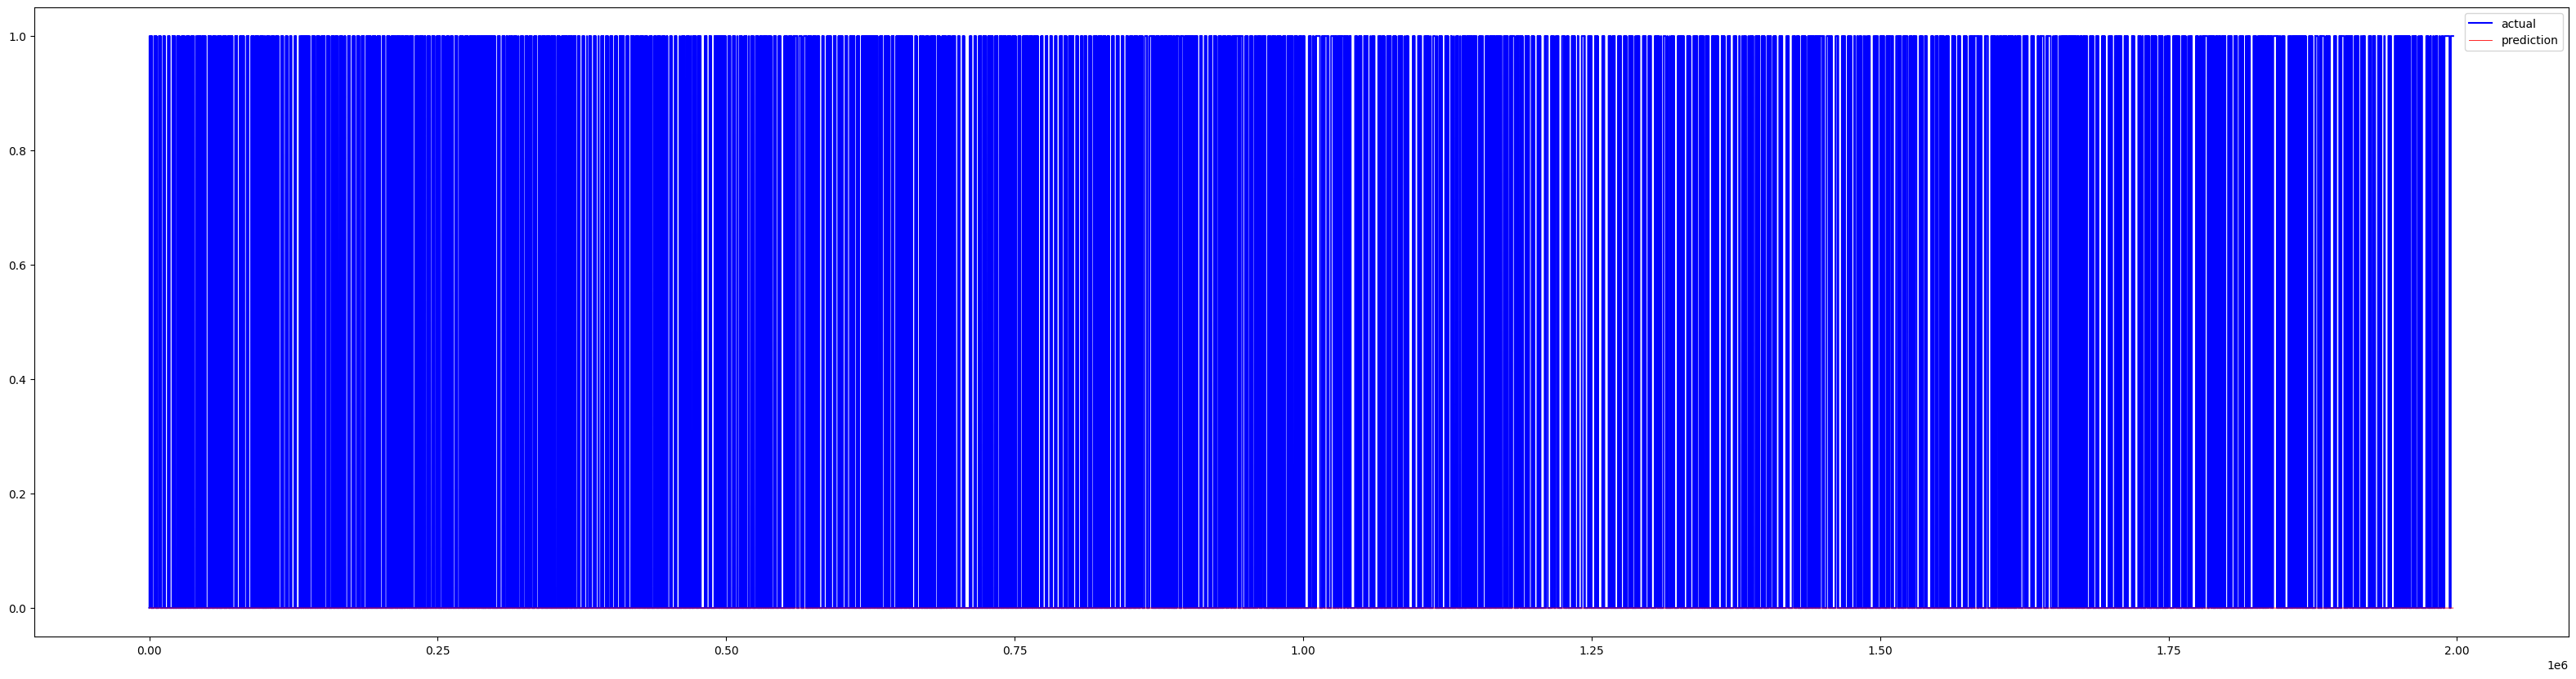


----------------------------------------------
the number of correct 1190109
the number of uncorrect 806670

confusion matrix
TP: 0
TN: 1190109
FP: 0
FN: 806670

accuracy: 0.5960143811608596


In [29]:
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []
    for data in test_loader:
        seq, target = data 
        out = pretrained_model(seq)
        targetting += target.cpu().numpy().tolist()
        test_pred += out.cpu().numpy().round().tolist()
        
    actual = targetting
    total = test_pred       
    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

---

# 한 개의 Task를 적용

In [30]:
# Meta learning (Few shot dataset - random: 1 ~ 7,987,200)
def Test_data(x, y, seq_len):
    x_seq = []
    y_seq = []

    RandomDataSetIdx = random.randint(6, 7)     #not hidden size -> map dataset (8)
    RandomDataSetloc = SAMPLE_NUM * RandomDataSetIdx

    for i in range(RandomDataSetloc, SAMPLE_NUM + RandomDataSetloc - SaturationForRange):
            x_seq.append(x[i:i+seq_len])
            y_seq.append(y[i+seq_len+1])

    x_seq = np.array(x_seq)        
    y_seq = np.array(y_seq)

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

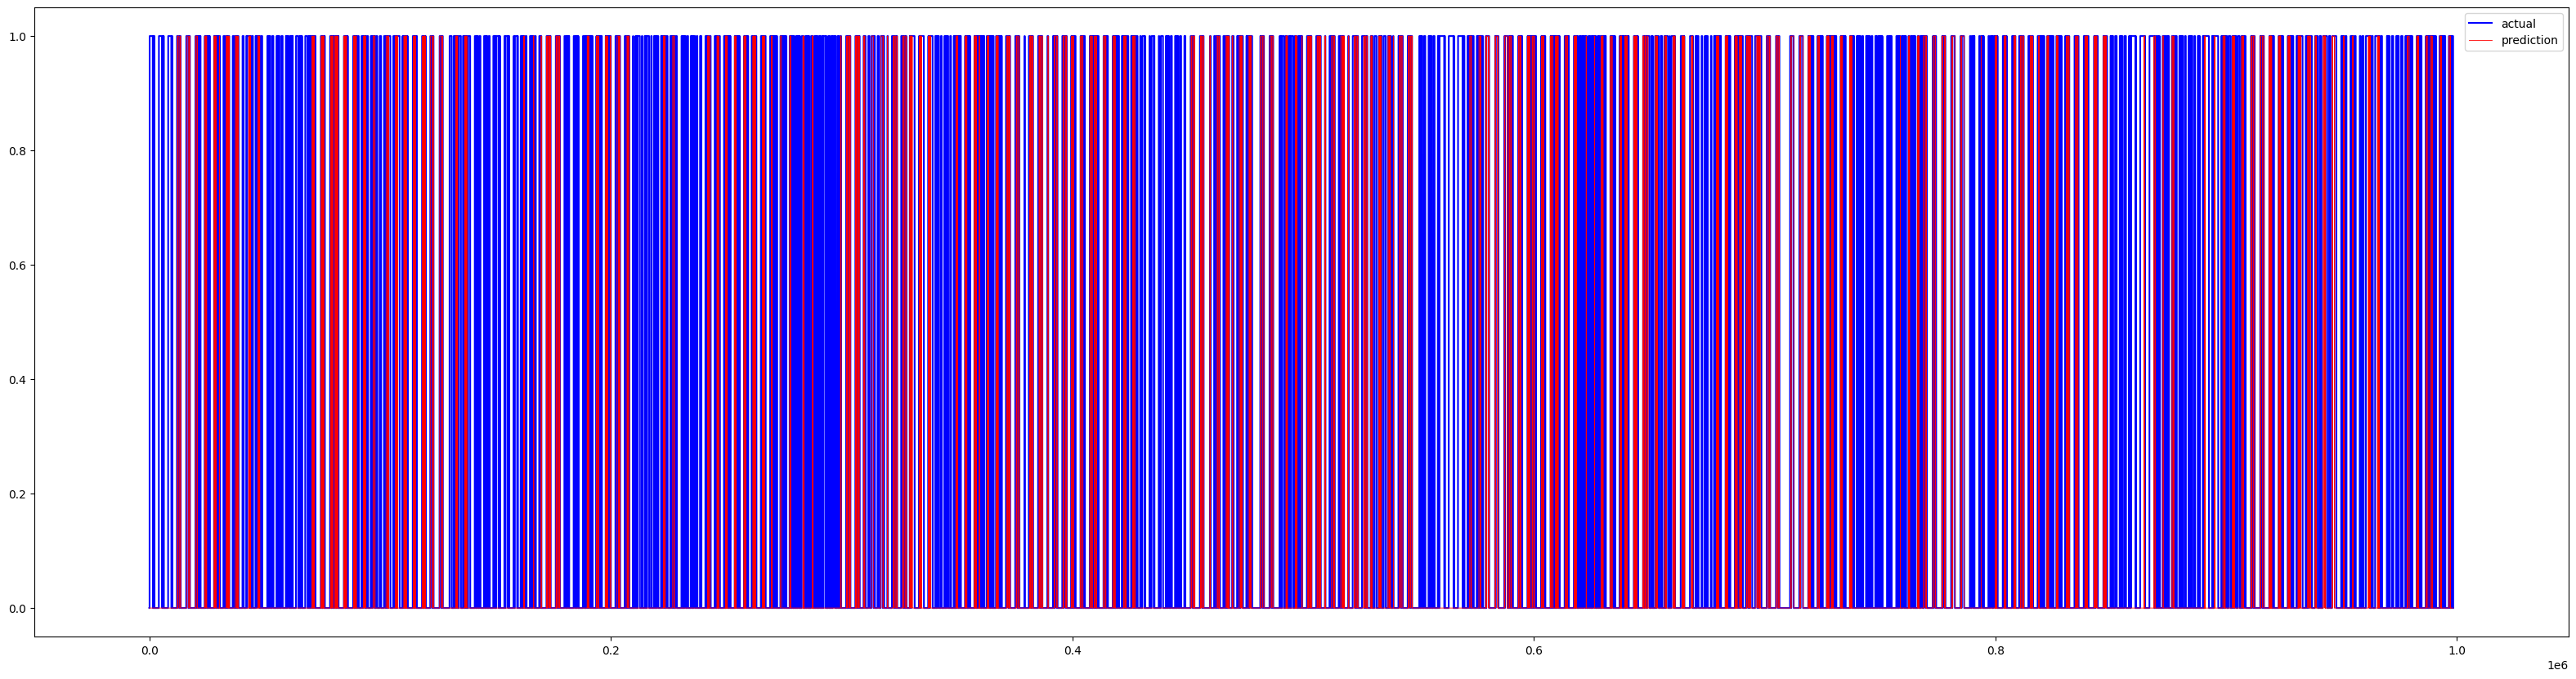


----------------------------------------------
the number of correct 736277
the number of uncorrect 262102

confusion matrix
TP: 124309
TN: 611968
FP: 3563
FN: 258539

accuracy: 0.7374724428298272


In [31]:
test_features, test_labels = Test_data(X, y, SEQ_LEN)
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []

    seq = test_features
    target = test_labels
    out = maml.model(seq)
    targetting += target.cpu().numpy().tolist()
    test_pred += out.cpu().numpy().round().tolist()
    
    actual = targetting
    total = test_pred       

    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

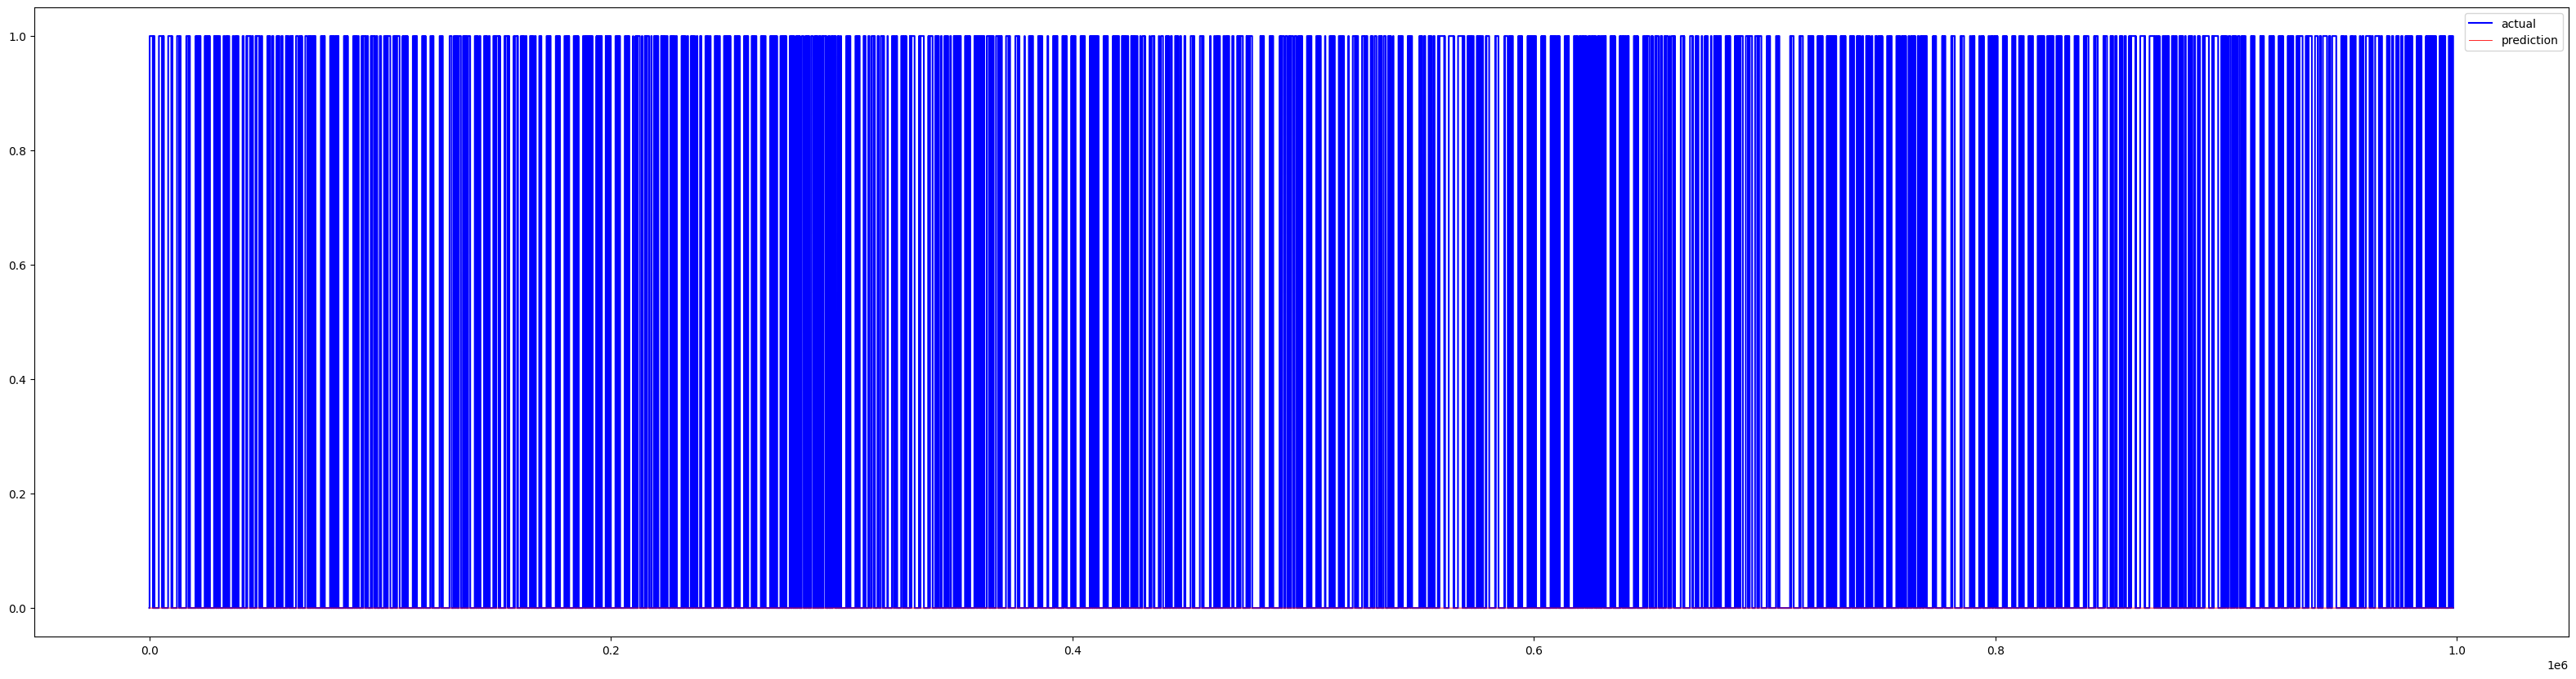


----------------------------------------------
the number of correct 615531
the number of uncorrect 382848

confusion matrix
TP: 0
TN: 615531
FP: 0
FN: 382848

accuracy: 0.6165303957715457


In [32]:
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []

    seq = test_features
    target = test_labels
    out = pretrained_model(seq)
    targetting += target.cpu().numpy().tolist()
    test_pred += out.cpu().numpy().round().tolist()
    
    actual = targetting
    total = test_pred       

    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

---

# result 1개

In [33]:
# Meta learning (Few shot dataset - random: 1 ~ 7,987,200)
def One_Test_data(x, y, seq_len):
    x_seq = []
    y_seq = []

    #9984
    RandomDataSetIdx = random.randint(7, 8)     #not hidden size -> map dataset (8)
    RandomDataResultIdx = random.randint(0, 99)     
    RandomDataSetloc = BATCH_SIZE * RandomDataSetIdx * RandomDataResultIdx

    for i in range(RandomDataSetloc, BATCH_SIZE + RandomDataSetloc - SaturationForRange):
            x_seq.append(x[i:i+seq_len])
            y_seq.append(y[i+seq_len+1])

    x_seq = np.array(x_seq)        
    y_seq = np.array(y_seq)

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

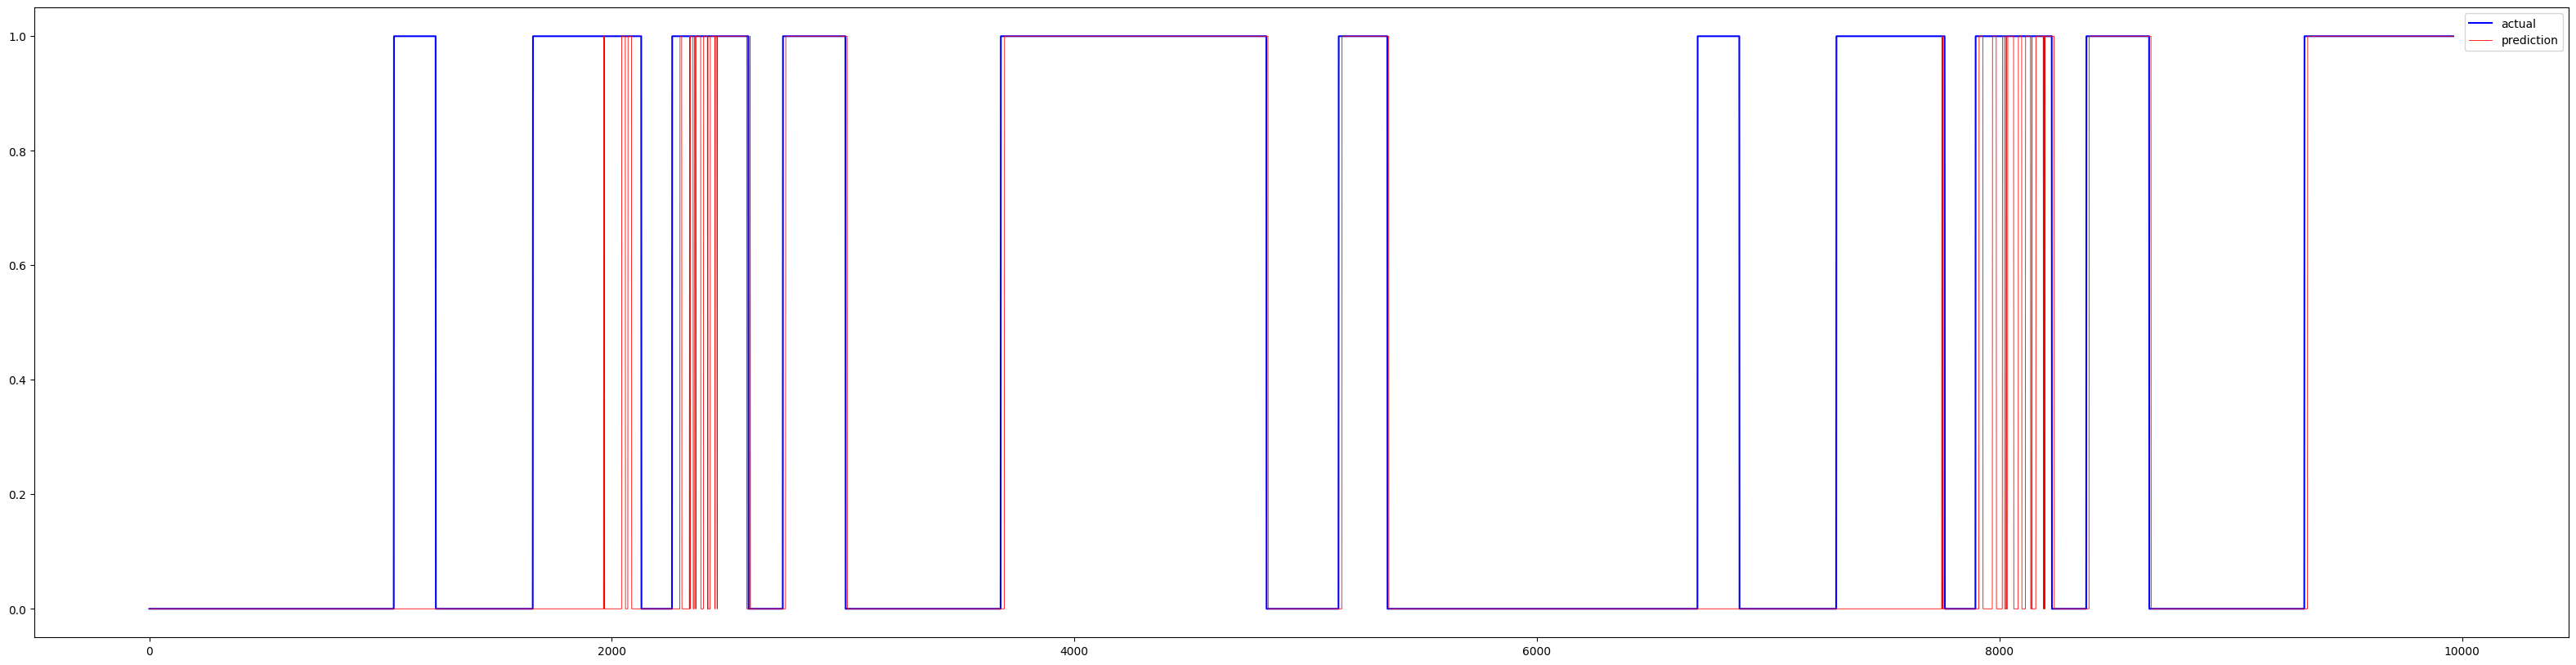


----------------------------------------------
the number of correct 8324
the number of uncorrect 1639

confusion matrix
TP: 2908
TN: 5416
FP: 40
FN: 1599

accuracy: 0.8354913178761417


In [40]:
One_test_features, One_test_labels = One_Test_data(X, y, SEQ_LEN)
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []

    seq = One_test_features
    target = One_test_labels
    out = maml.model(seq)
    targetting += target.cpu().numpy().tolist()
    test_pred += out.cpu().numpy().round().tolist()
    
    actual = targetting
    total = test_pred       

    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

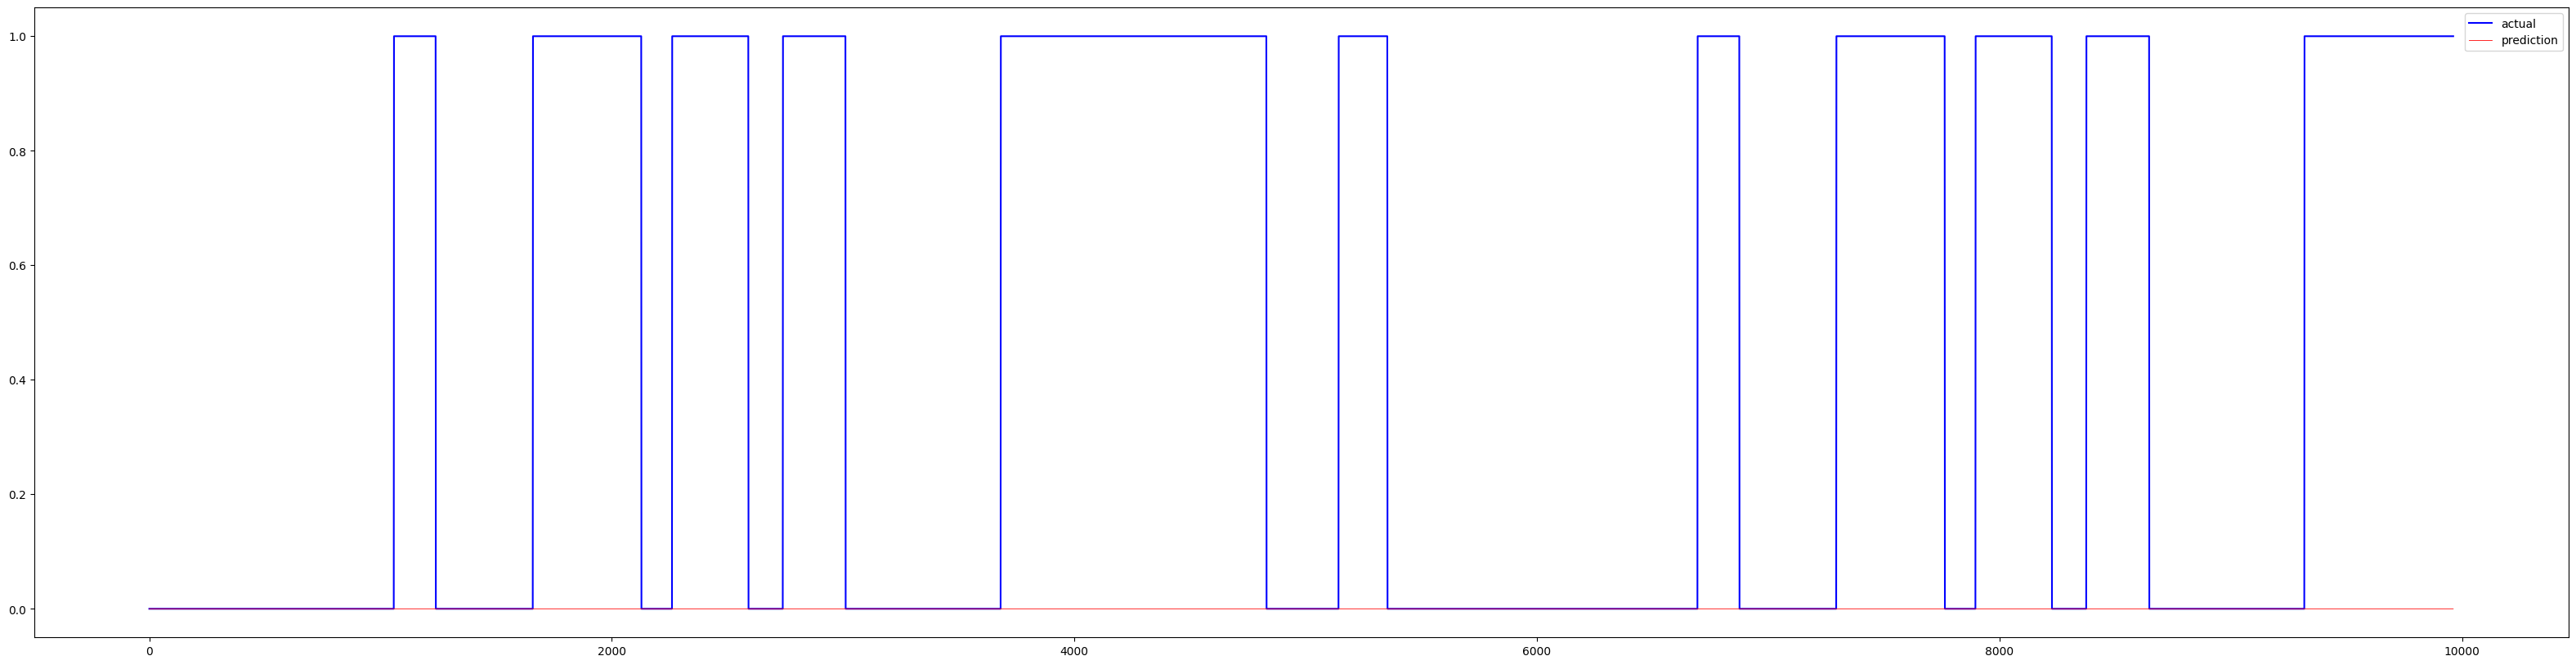


----------------------------------------------
the number of correct 5456
the number of uncorrect 4507

confusion matrix
TP: 0
TN: 5456
FP: 0
FN: 4507

accuracy: 0.5476262170029108


In [41]:
#One_test_features, One_test_labels = One_Test_data(X, y, SEQ_LEN)
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []

    seq = One_test_features
    target = One_test_labels
    out = pretrained_model(seq)
    targetting += target.cpu().numpy().tolist()
    test_pred += out.cpu().numpy().round().tolist()
    
    actual = targetting
    total = test_pred       

    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)